## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
import requests

import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## Load Data

###  London Borough Data

In [2]:
shp_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
shx_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shx'
dbf_url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.dbf'
# Add more URLs if there are other necessary files

# Download and save each file
for url in [shp_url, shx_url, dbf_url]:
    r = requests.get(url)
    with open(url.split('/')[-1], 'wb') as f:
        f.write(r.content)

# Now you can read the shapefile
borough = gpd.read_file('London_Borough_Excluding_MHW.shp')  # Use the name of your .shp file
print(borough.head(3))

                   NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  SUB_2009  \
0  Kingston upon Thames  E09000021  3,726.12        0.00         F       NaN   
1               Croydon  E09000008  8,649.44        0.00         F       NaN   
2               Bromley  E09000006 15,013.49        0.00         F       NaN   

   SUB_2006                                           geometry  
0       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...  
1       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...  
2       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...  


Map it to check

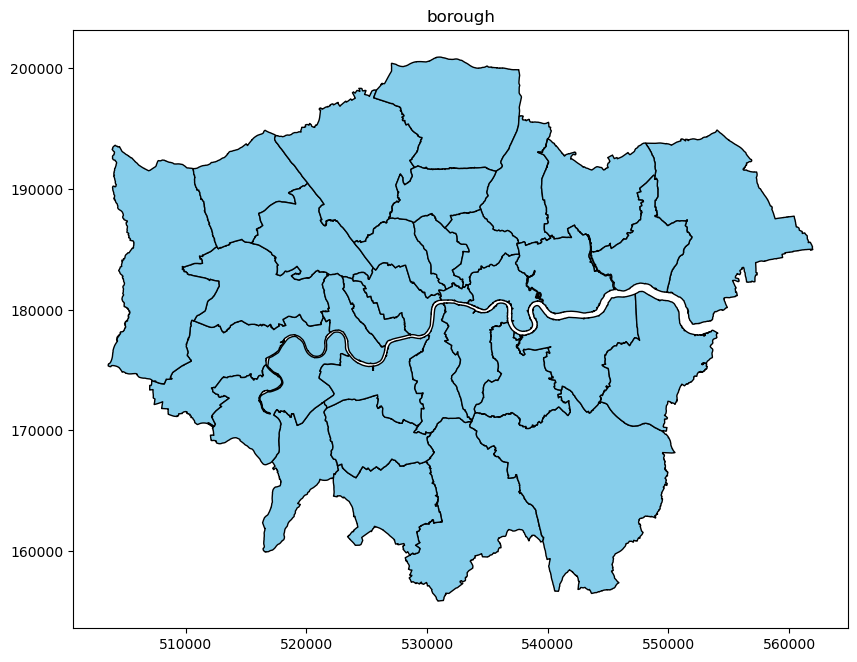

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
borough.plot(ax=ax, color='skyblue', edgecolor='black')
plt.title('borough')
plt.show()

### Airbnb Listing Data

In [4]:
url = 'https://github.com/parorrr/fsds_group-work/raw/main/data/listings.csv.gz'
listings = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 87,946 x 75


In [5]:
print(f"Data frame is {listings.shape[0]:,} x {listings.shape[1]}")

Data frame is 87,946 x 75


In [6]:
print(listings.head(3))

      id                         listing_url       scrape_id last_scraped  \
0  92644  https://www.airbnb.com/rooms/92644  20230906022807   2023-09-06   
1  93015  https://www.airbnb.com/rooms/93015  20230906022807   2023-09-06   
2  13913  https://www.airbnb.com/rooms/13913  20230906022807   2023-09-06   

        source                                               name  \
0  city scrape  Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1  city scrape  Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2  city scrape  Rental unit in Islington · ★4.80 · 1 bedroom ·...   

                                         description  \
0  <b>The space</b><br />Hi everyone! I have 2 ro...   
1  Gorgeous 2 bed ground floor apartment with per...   
2  My bright double bedroom with a large window h...   

                               neighborhood_overview  \
0                                                NaN   
1  A bit of history about the W14 area: <br />Com...   
2  Finsbury Park is a

In [7]:
listings.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

In [8]:
listings.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,92644,https://www.airbnb.com/rooms/92644,20230906022807,2023-09-06,city scrape,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,NaN,https://a0.muscache.com/pictures/715127/85bdb4...,498201,...,4.67,4.53,4.68,NaN,t,1,0,1,0,1.45
1,93015,https://www.airbnb.com/rooms/93015,20230906022807,2023-09-06,city scrape,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,A bit of history about the W14 area: <br />Com...,https://a0.muscache.com/pictures/865937ec-ee56...,499704,...,4.88,4.85,4.74,NaN,f,1,1,0,0,0.27
2,13913,https://www.airbnb.com/rooms/13913,20230906022807,2023-09-06,city scrape,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.82,4.69,4.69,NaN,f,2,1,1,0,0.26


## Clear Listings Data

In [10]:
# Select variables of interest
listings = listings[['id','neighbourhood_cleansed','host_listings_count','accommodates','price','availability_365']]
#check output and datatypes
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      87946 non-null  int64  
 1   neighbourhood_cleansed  87946 non-null  object 
 2   host_listings_count     87941 non-null  float64
 3   accommodates            87946 non-null  int64  
 4   price                   87946 non-null  object 
 5   availability_365        87946 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.0+ MB


In [11]:
# 列出所有需要检查的列
columns_to_check = ['neighbourhood_cleansed', 'host_listings_count', 'accommodates', 'price', 'availability_365']

# 使用字典来存储每列缺失值的数量
missing_values = {col: listings[col].isnull().sum() for col in columns_to_check}

# 打印每列的缺失值数量
for col, num_missing in missing_values.items():
    print(f"Number of missing values in '{col}': {num_missing}")


Number of missing values in 'neighbourhood_cleansed': 0
Number of missing values in 'host_listings_count': 5
Number of missing values in 'accommodates': 0
Number of missing values in 'price': 0
Number of missing values in 'availability_365': 0


In [12]:
# 给定的示例
listings.dropna(subset=['host_listings_count'], inplace=True)

# 如果你还想删除其他列中包含缺失值的行
columns_to_drop_na = ['neighbourhood_cleansed', 'accommodates', 'price', 'availability_365']
listings.dropna(subset=columns_to_drop_na, inplace=True)


In [13]:
# 列出所有需要检查的列
columns_to_check = ['neighbourhood_cleansed', 'host_listings_count', 'accommodates', 'price', 'availability_365']

# 使用字典来存储每列缺失值的数量
missing_values = {col: listings[col].isnull().sum() for col in columns_to_check}

# 打印每列的缺失值数量
for col, num_missing in missing_values.items():
    print(f"Number of missing values in '{col}': {num_missing}")

Number of missing values in 'neighbourhood_cleansed': 0
Number of missing values in 'host_listings_count': 0
Number of missing values in 'accommodates': 0
Number of missing values in 'price': 0
Number of missing values in 'availability_365': 0


In [14]:
listings['price'] = listings['price'].astype(str).str.replace(",", "").str.replace("$", "").astype(float)

In [15]:
listings.to_csv('listings.csv', index=False)

## Group Data per Borough

In [26]:
# Aggregate total availability days per neighbourhood
availability_grouped = listings.groupby('neighbourhood_cleansed')['availability_365'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
availability_grouped = availability_grouped.merge(listings_count, on='neighbourhood_cleansed')

# Calculate the occupancy rate directly
availability_grouped['occupancy_rate'] = (365 - (availability_grouped['availability_365'] / availability_grouped['listing_count'])) / 365

# Viewing the results
print(availability_grouped[['neighbourhood_cleansed', 'occupancy_rate']])

# Exporting to CSV
availability_grouped.to_csv('occupancy_rate.csv', index=False)

    neighbourhood_cleansed  occupancy_rate
0     Barking and Dagenham            0.52
1                   Barnet            0.59
2                   Bexley            0.43
3                    Brent            0.63
4                  Bromley            0.57
5                   Camden            0.68
6           City of London            0.63
7                  Croydon            0.54
8                   Ealing            0.62
9                  Enfield            0.50
10               Greenwich            0.59
11                 Hackney            0.77
12  Hammersmith and Fulham            0.69
13                Haringey            0.70
14                  Harrow            0.53
15                Havering            0.44
16              Hillingdon            0.48
17                Hounslow            0.57
18               Islington            0.75
19  Kensington and Chelsea            0.63
20    Kingston upon Thames            0.66
21                 Lambeth            0.72
22         

In [28]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['host_listings_count'].sum().reset_index()
# 合并数据
merged_data = borough.merge(listings_grouped, left_on='NAME', right_on='neighbourhood_cleansed')
# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
merged_data['host_density'] = merged_data['host_listings_count'] / merged_data['HECTARES']
# 查看结果
print(merged_data[['neighbourhood_cleansed', 'host_density']])
# 导出到 CSV
merged_data.to_csv('host_density.csv', index=False)


    neighbourhood_cleansed  host_density
0     Kingston upon Thames          3.54
1                  Croydon          3.54
2                  Bromley          0.55
3                 Hounslow         23.90
4                   Ealing         14.19
5                 Havering          0.98
6               Hillingdon          3.12
7                   Harrow          3.01
8                    Brent         78.96
9                   Barnet         24.13
10                 Lambeth         56.26
11               Southwark         96.13
12                Lewisham          9.78
13               Greenwich         15.20
14                  Bexley          1.83
15                 Enfield          0.96
16          Waltham Forest          5.96
17               Redbridge          4.02
18                  Sutton          2.43
19    Richmond upon Thames          2.85
20                  Merton          7.12
21              Wandsworth         28.08
22  Hammersmith and Fulham         54.34
23  Kensington a

In [29]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['accommodates'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
listings_grouped = listings_grouped.merge(listings_count, on='neighbourhood_cleansed')

# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
listings_grouped['average_accommodates'] = listings_grouped['accommodates'] / listings_grouped['listing_count']
# 查看结果
print(listings_grouped[['neighbourhood_cleansed', 'average_accommodates']])
# 导出到 CSV
listings_grouped.to_csv('average_accommodates.csv', index=False)

    neighbourhood_cleansed  average_accommodates
0     Barking and Dagenham                  3.04
1                   Barnet                  3.28
2                   Bexley                  2.87
3                    Brent                  3.10
4                  Bromley                  3.12
5                   Camden                  3.29
6           City of London                  3.01
7                  Croydon                  2.91
8                   Ealing                  3.01
9                  Enfield                  2.96
10               Greenwich                  3.24
11                 Hackney                  2.91
12  Hammersmith and Fulham                  3.28
13                Haringey                  3.12
14                  Harrow                  2.77
15                Havering                  3.38
16              Hillingdon                  2.78
17                Hounslow                  2.88
18               Islington                  3.03
19  Kensington and C

In [30]:
# 聚合住房数据
listings_grouped = listings.groupby('neighbourhood_cleansed')['price'].sum().reset_index()

# Count the number of listings per neighbourhood
listings_count = listings.groupby('neighbourhood_cleansed').size().reset_index(name='listing_count')

# Merge the count with the merged data
listings_grouped = listings_grouped.merge(listings_count, on='neighbourhood_cleansed')

# 计算住宅密度
# 假设 boroughs DataFrame 有一个名为 'area' 的面积列
listings_grouped['average_price'] = listings_grouped['price'] / listings_grouped['listing_count']
# 查看结果
print(listings_grouped[['neighbourhood_cleansed', 'average_price']])
# 导出到 CSV
listings_grouped.to_csv('average_price.csv', index=False)

    neighbourhood_cleansed  average_price
0     Barking and Dagenham         245.84
1                   Barnet         160.52
2                   Bexley          95.05
3                    Brent         179.08
4                  Bromley         105.97
5                   Camden         203.32
6           City of London         243.72
7                  Croydon          91.07
8                   Ealing         125.22
9                  Enfield         107.16
10               Greenwich         122.00
11                 Hackney         132.93
12  Hammersmith and Fulham         177.23
13                Haringey         149.83
14                  Harrow         105.49
15                Havering         118.19
16              Hillingdon         103.41
17                Hounslow         182.46
18               Islington         173.17
19  Kensington and Chelsea         307.43
20    Kingston upon Thames         134.80
21                 Lambeth         141.04
22                Lewisham        

## Combine All the Grouped Data

In [37]:
host_density = pd.read_csv('host_density.csv', low_memory=False)
occupancy_rate = pd.read_csv('occupancy_rate.csv', low_memory=False)
average_accommodates = pd.read_csv('average_accommodates.csv', low_memory=False)
average_price = pd.read_csv('average_price.csv', low_memory=False)

host_density.drop('neighbourhood_cleansed', axis=1, inplace=True)
occupancy_rate1 = occupancy_rate[['neighbourhood_cleansed', 'occupancy_rate']]
average_accommodates1 = average_accommodates[['neighbourhood_cleansed', 'average_accommodates']]
average_price1 = average_price[['neighbourhood_cleansed', 'average_price']]

merged_listings_borough = host_density.merge(occupancy_rate1, left_on='NAME', right_on='neighbourhood_cleansed')
merged_listings_borough = merged_listings_borough.merge(average_accommodates1, left_on='NAME', right_on='neighbourhood_cleansed')
merged_listings_borough = merged_listings_borough.merge(average_price1, left_on='NAME', right_on='neighbourhood_cleansed')
merged_listings_borough.drop('neighbourhood_cleansed', axis=1, inplace=True)
merged_listings_borough.drop('neighbourhood_cleansed_x', axis=1, inplace=True)
merged_listings_borough.drop('neighbourhood_cleansed_y', axis=1, inplace=True)
merged_listings_borough.to_csv('merged_listings_borough.csv', index=False)